In [3]:
import scvelo as scv
from IPython.display import clear_output
import matplotlib.backends.backend_pdf
from tqdm import tnrange, tqdm_notebook
import scanpy as sc
import matplotlib.pyplot as pl
import pandas as pd
import numpy as np
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline


scv.logging.print_version()
scv.settings.set_figure_params(
    'scvelo', dpi_save=100, dpi=80, transparent=True)
scv.settings.verbosity = 2

Running scvelo 0.1.16.dev32+c00a55e.dirty (python 3.6.6) on 2020-12-14 13:55.


In [7]:
# paths and names
data_path='G:/data/scSLAMseq/revision/'
signatures_path='G:/data/scrnaseq_signature_collection/'
figure_path='G:/data/figures/'
libraries = ['AB', 'CE', 'DF']
donors=['B2-040', 'C2-019', 'OT227', 'OT302', 'P009T', 'P013T']
pert_colors=['#fff989', '#858585', '#c31f26', '#ff7f26', '#af3cb1', '#00a8f3']

# (Explanation)

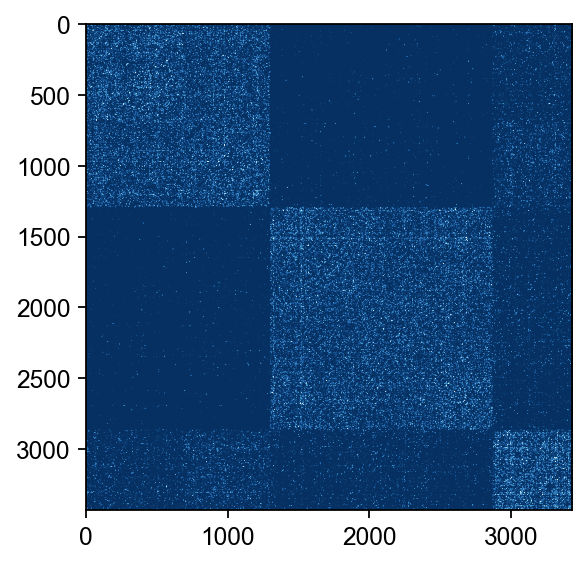

In [5]:
donor = donors[-1]
adata=scv.read(data_path+'by_donors/processed/SLAMv2_'+donor+'_processed_ccreg.h5')

# recompute KNN graph
del adata.obsm['X_diffmap']
sc.pp.neighbors(adata)

cons = adata.uns['neighbors']['connectivities']
pl.imshow(cons.A, vmax=0.1)

$ y_j^q=1$ if cell $j$ is of condition $q$ and $ x_i^p=1$ if cell $i$ is of condition $p$.
$A$ is the connectivity matrix of the KNN graph. Most notably $a_{ij}\neq0$ if cells $i$ and $j$ are KNNs.
We calculate $$\hat{x}_i^{p,q}=\frac{\sum_j x_i^p a_{ij} y_j^q}{\sum_jx_i^p a_{ij}}$$ 

which is the fraction of cells from condition $q$ of all KNNs of $x_i$.
Further, we correct for the cell number in perturbation q by $$ \hat{z}^{p,q}_i=\hat{x}_i^{p,q}\cdot \frac{N}{c\sum_jy_j^q}$$ 

where $N$ is the total number of cells and $c$ the number of different perturbations. We take the mean over all such fractions per cell $i$ to get a global estimate: 
$$z^{p,q}=\frac{\sum_i\hat{z}^{p,q}_i}{\sum_ix_i^p}$$

Finally, we symmetrize to obtain a empirical measure for the KNN-similarity of perturbations:
$$sim(p,q)=\frac{1}{2}(z^{p,q}+ z^{q,p})$$


Text(0.5, 0.98, 'P013T KNN Label Similarity')

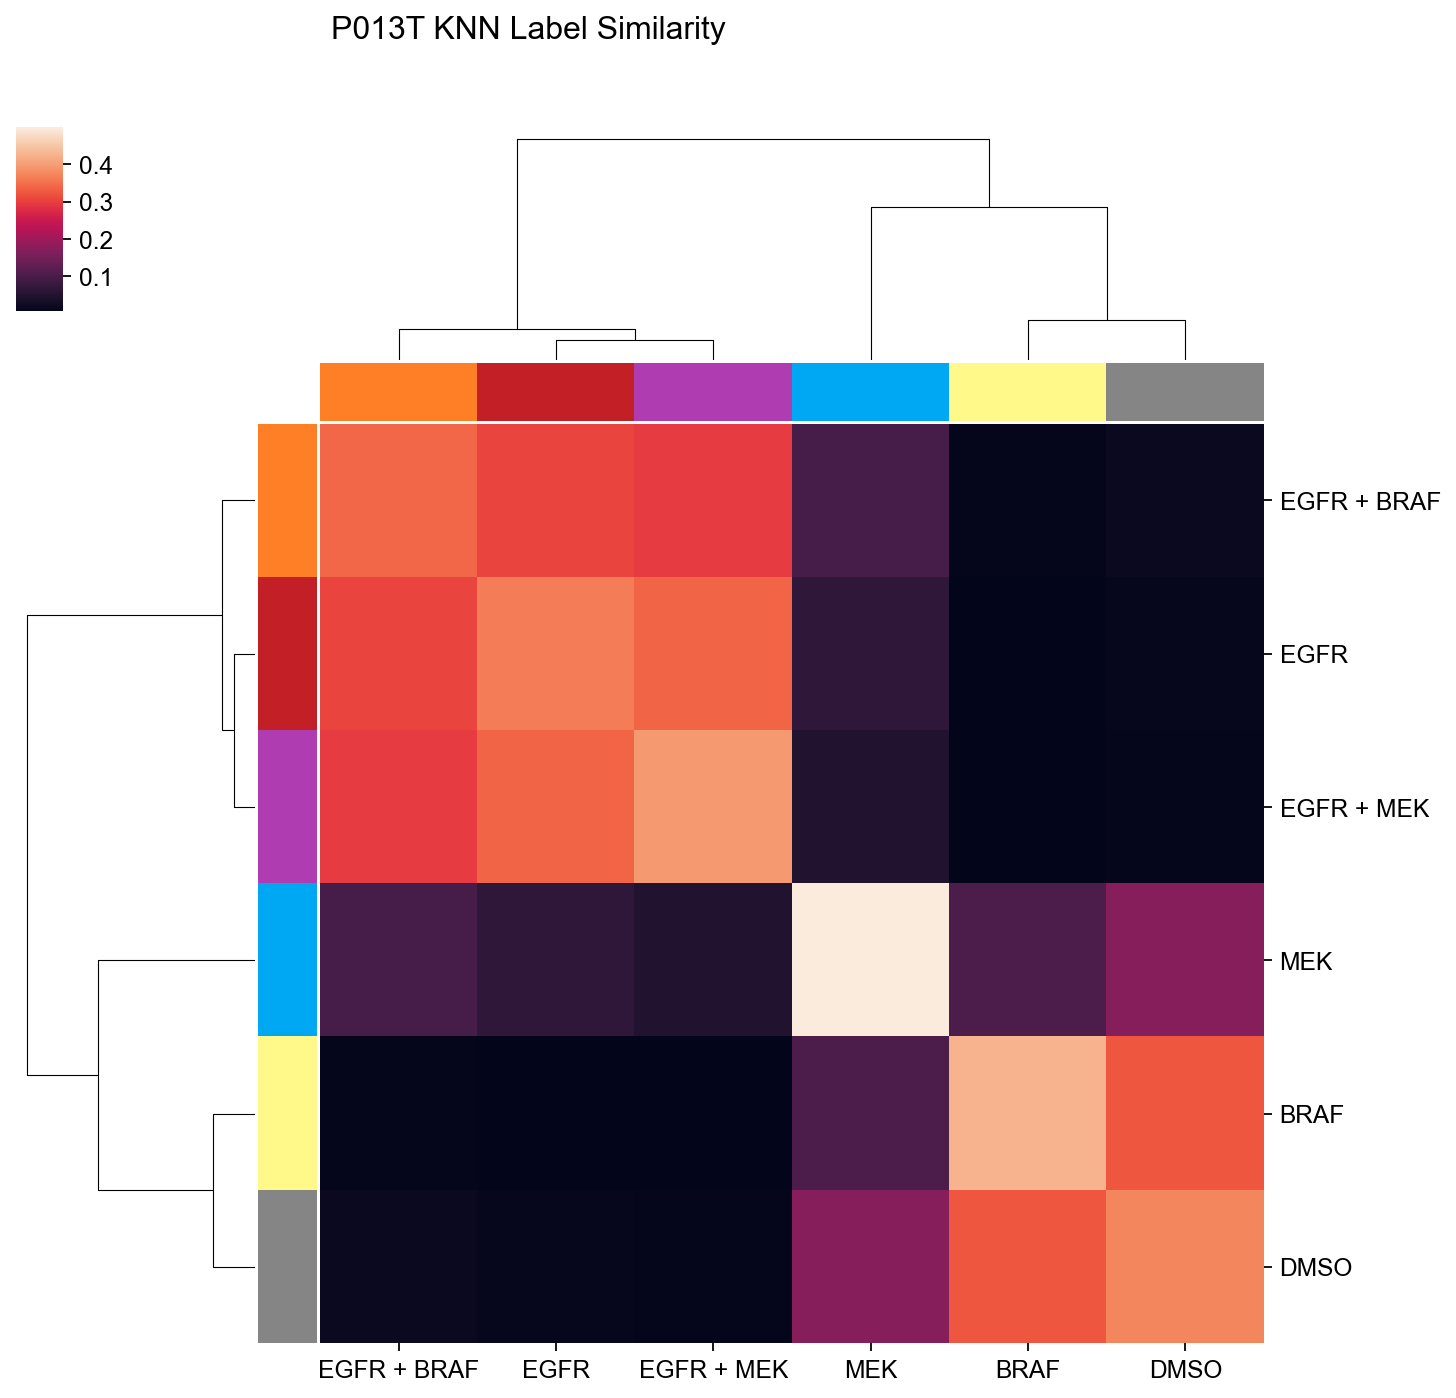

In [31]:
cons = adata.uns['neighbors']['connectivities']
dists = adata.uns['neighbors']['distances']

conds=pd.unique(adata.obs['perturbation'])
K = len(conds)
cond_sim = np.zeros((K,K))

A = (cons).A  # weights (KNN), is symmetric
d = np.sum(A,axis=1)  # total weight of neighbors for cells

for i, c1 in enumerate(conds):
    for j, c2 in enumerate(conds):
        x = (adata.obs.perturbation==c1).values*1.0  # mask of cells with perturbation c1
        y = (adata.obs.perturbation==c2).values*1.0  # mask of cells with perturbation c2
        cond_sim[i,j] = np.dot(np.dot(x,A)/d, y)/np.sum(x)  # mean fraction of c2 cells on the KNNs of c1 cells (not symmetric)
        cond_sim[i,j]*=(adata.n_obs/(np.sum(y)*len(conds)))  # correct for imbalance in cell numbers per condition
# symmetrize
cond_sim = 0.5*(cond_sim+cond_sim.T)  # symmetrized connectivity weighted mean fraction of c2 cells on the KNNs of c1 cells (not symmetric)

sim_df = pd.DataFrame(cond_sim, conds, conds)

from seaborn import clustermap
g=clustermap(sim_df, row_colors=pert_colors, col_colors=pert_colors)
g.fig.suptitle(donor+' KNN Label Similarity')

# Compute and plot

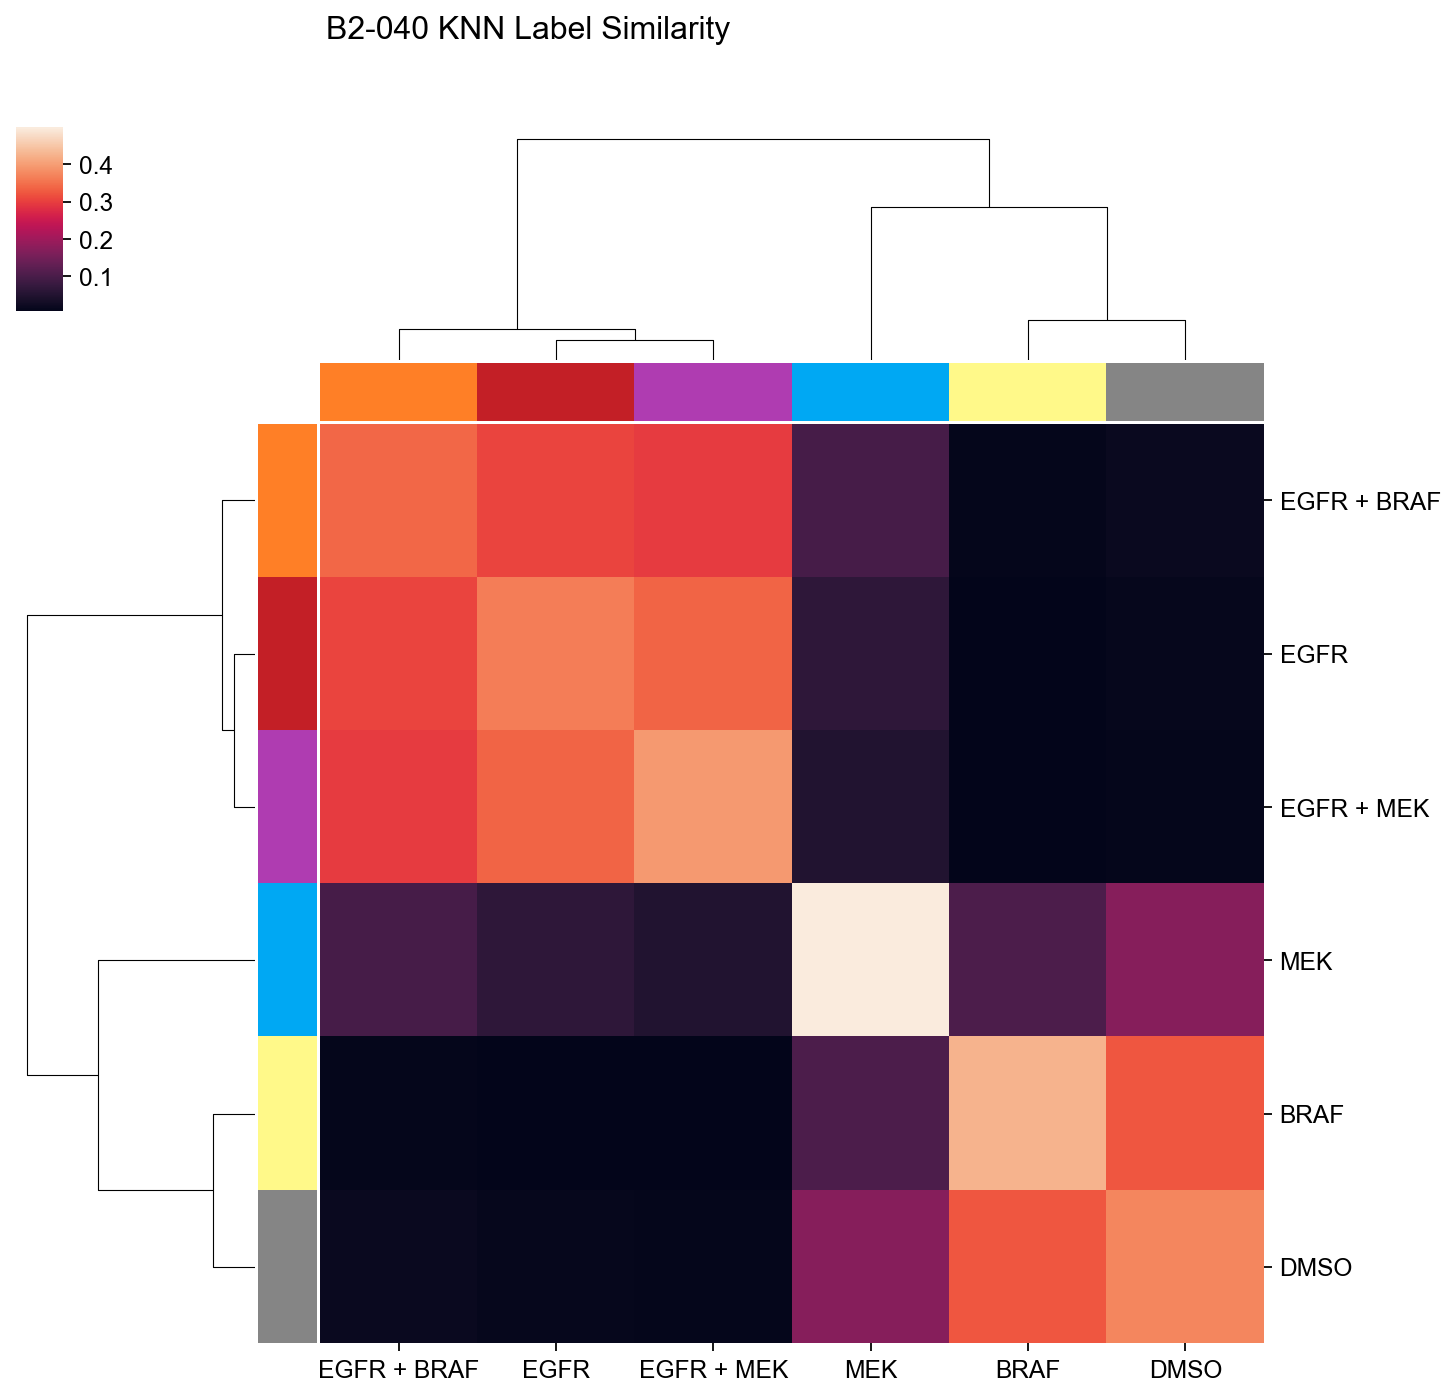

In [34]:
from pathlib import Path
Path(figure_path+'perturbation_distance_heatmaps/').mkdir(parents=True, exist_ok=True)

def simil(adata):
    cons = adata.uns['neighbors']['connectivities']
    dists = adata.uns['neighbors']['distances']

    conds=pd.unique(adata.obs['perturbation'])
    K = len(conds)
    cond_sim = np.zeros((K,K))
    
    A = (cons).A  # weights (KNN), is symmetric
    #A = (dists>0).A  # adjacency (KNN), is symmetric
    #d = np.sum(A>0,axis=1)  # number of neighbors for cells
    d = np.sum(A,axis=1)  # total weight of neighbors for cells

    for i, c1 in enumerate(conds):
        for j, c2 in enumerate(conds):
            x = (adata.obs.perturbation==c1).values*1.0  # mask of cells with perturbation c1
            y = (adata.obs.perturbation==c2).values*1.0  # mask of cells with perturbation c2
            cond_sim[i,j] = np.dot(np.dot(x,A)/d, y)/np.sum(x)  # mean fraction of c2 cells on the KNNs of c1 cells (not symmetric)
            cond_sim[i,j]*=(adata.n_obs/(np.sum(y)*len(conds)))  # correct for imbalance in cell numbers per condition
    # symmetrize
    cond_sim = 0.5*(cond_sim+cond_sim.T)  # symmetrized KNN mean fraction of connectivity weighted c2 cells on the KNNs of c1 cells (not symmetric)

    sim_df = pd.DataFrame(cond_sim, conds, conds)

    from seaborn import clustermap
    g=clustermap(sim_df, row_colors=pert_colors, col_colors=pert_colors)
    g.fig.suptitle(donor+' KNN Label Similarity')
    return sim_df

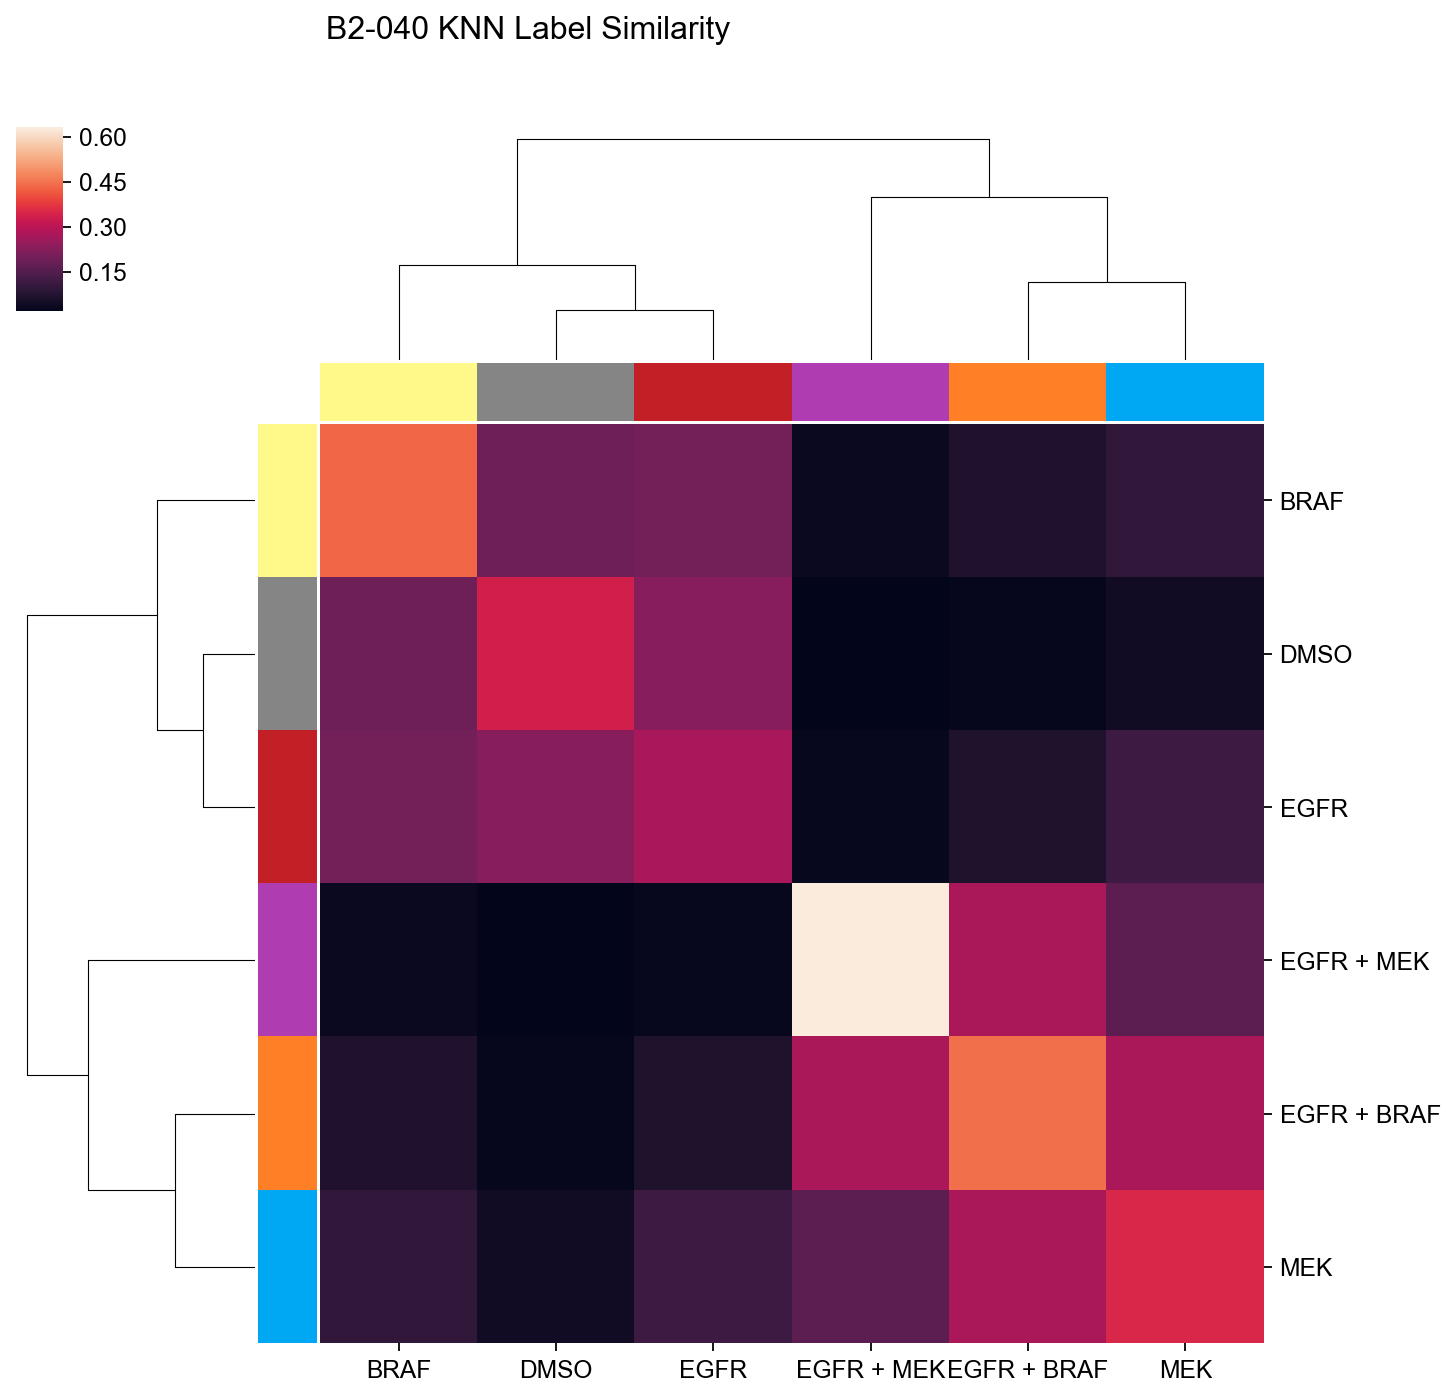

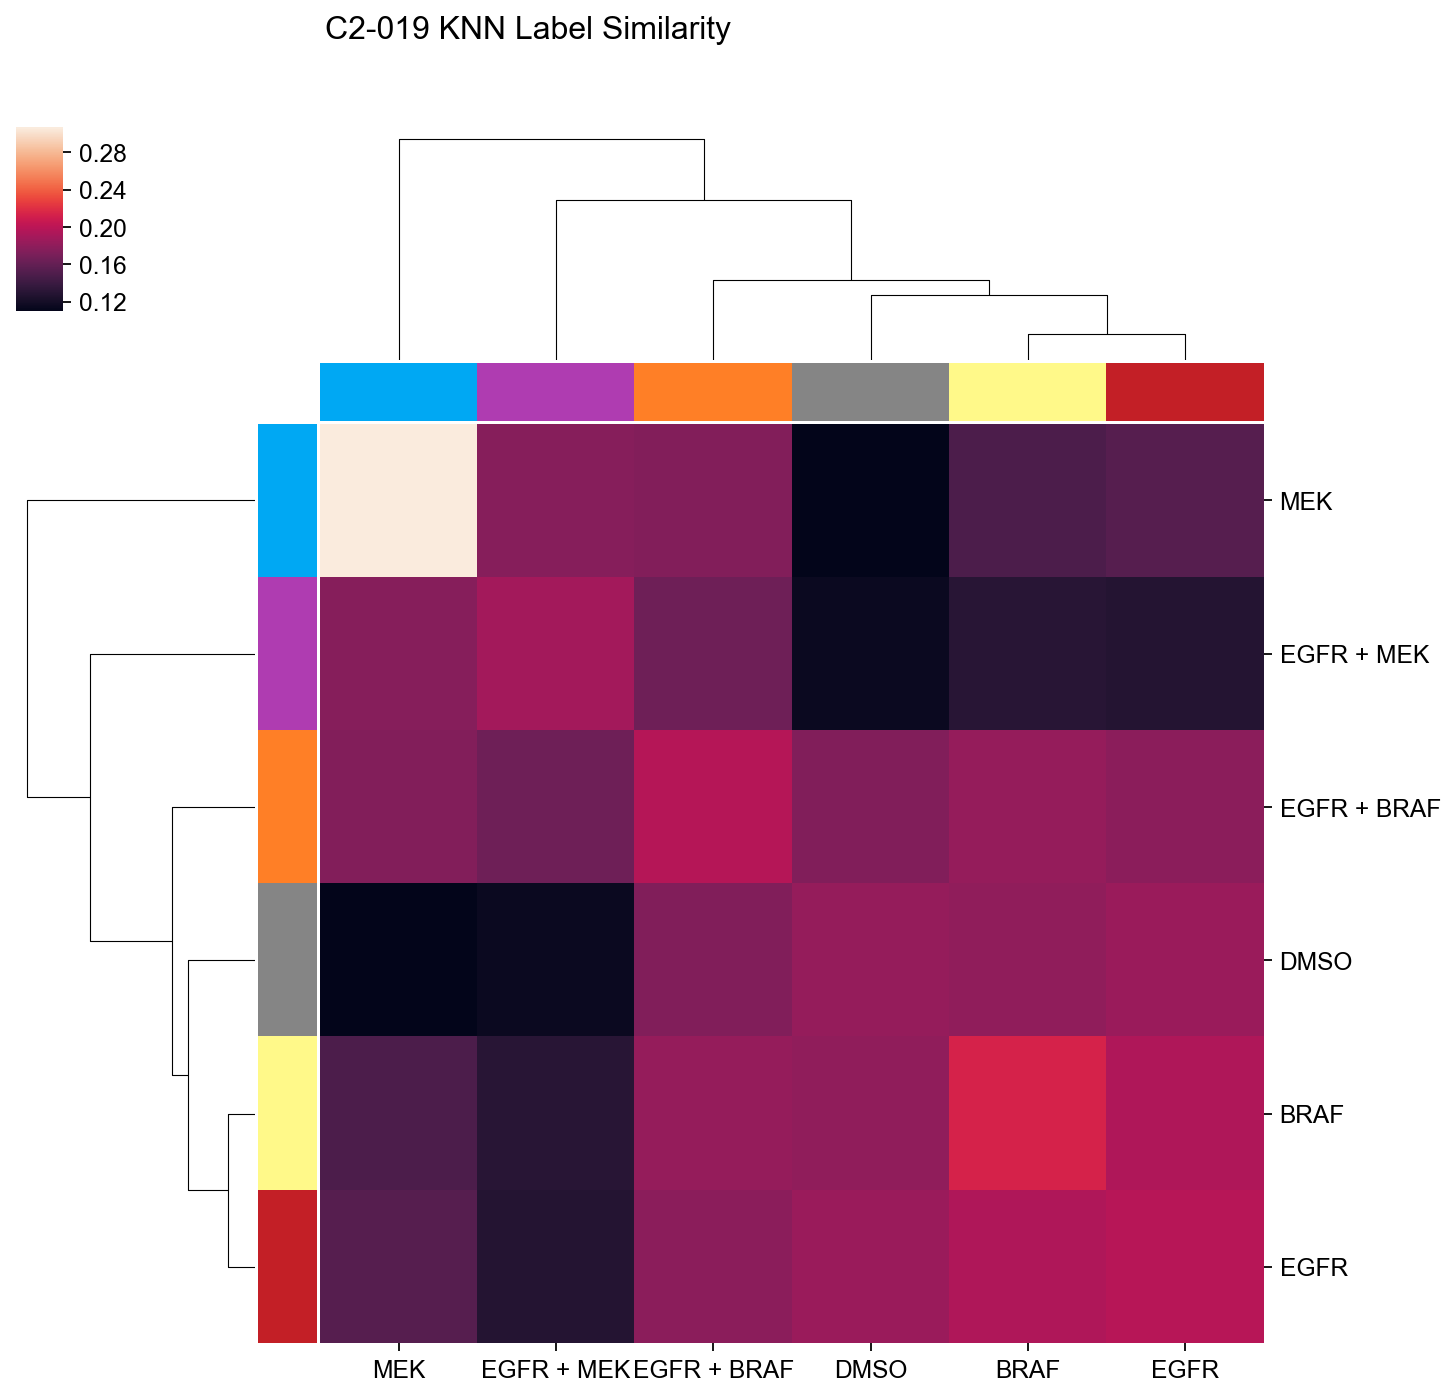

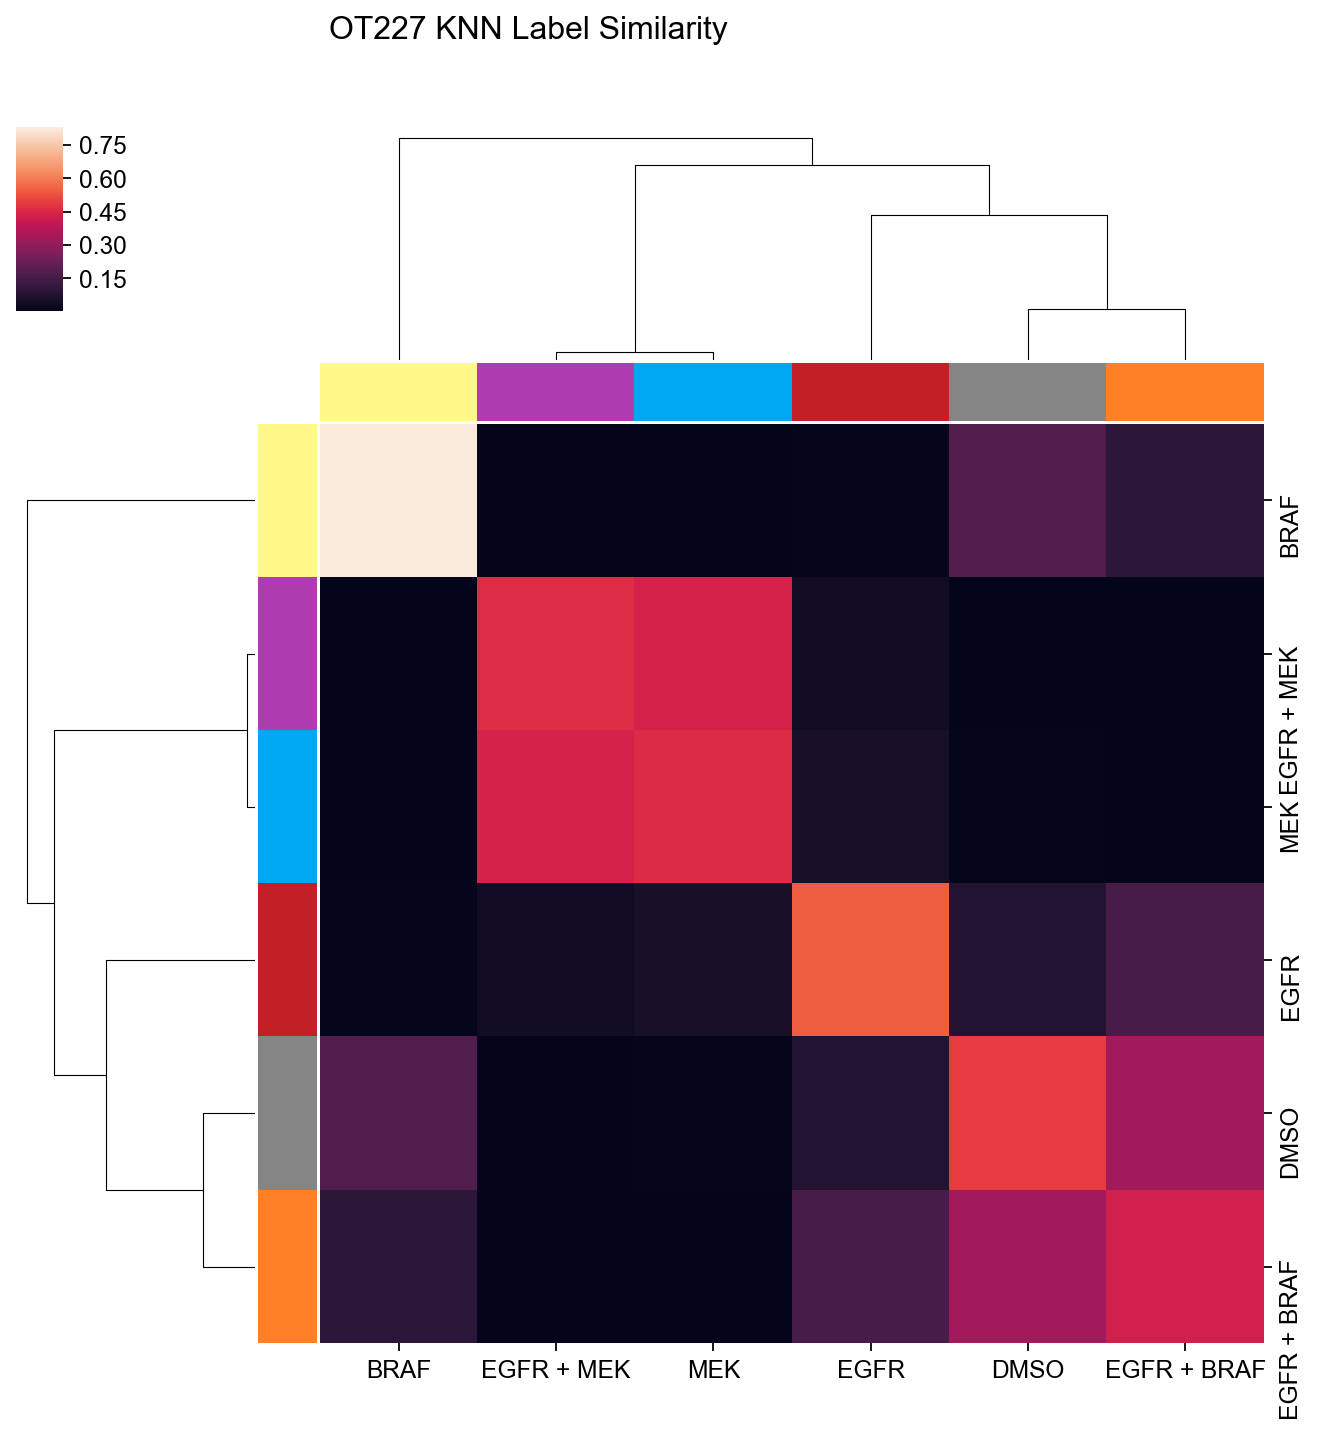

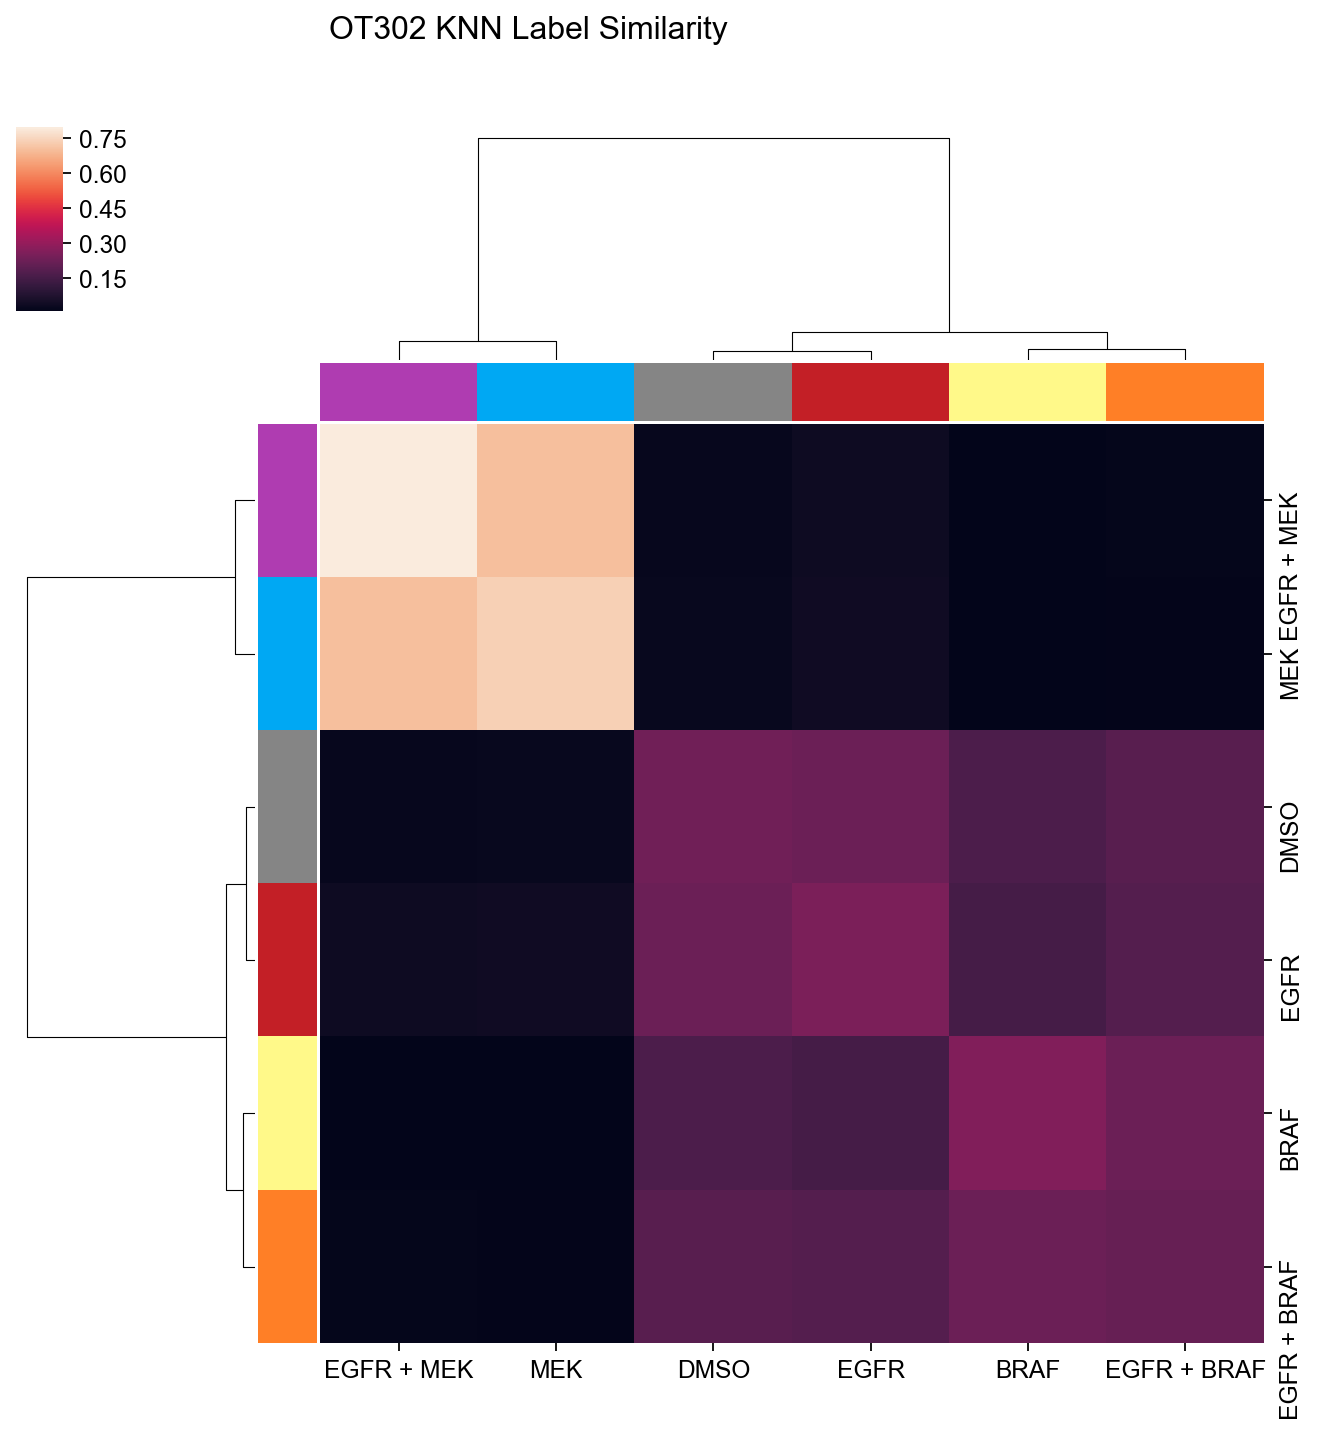

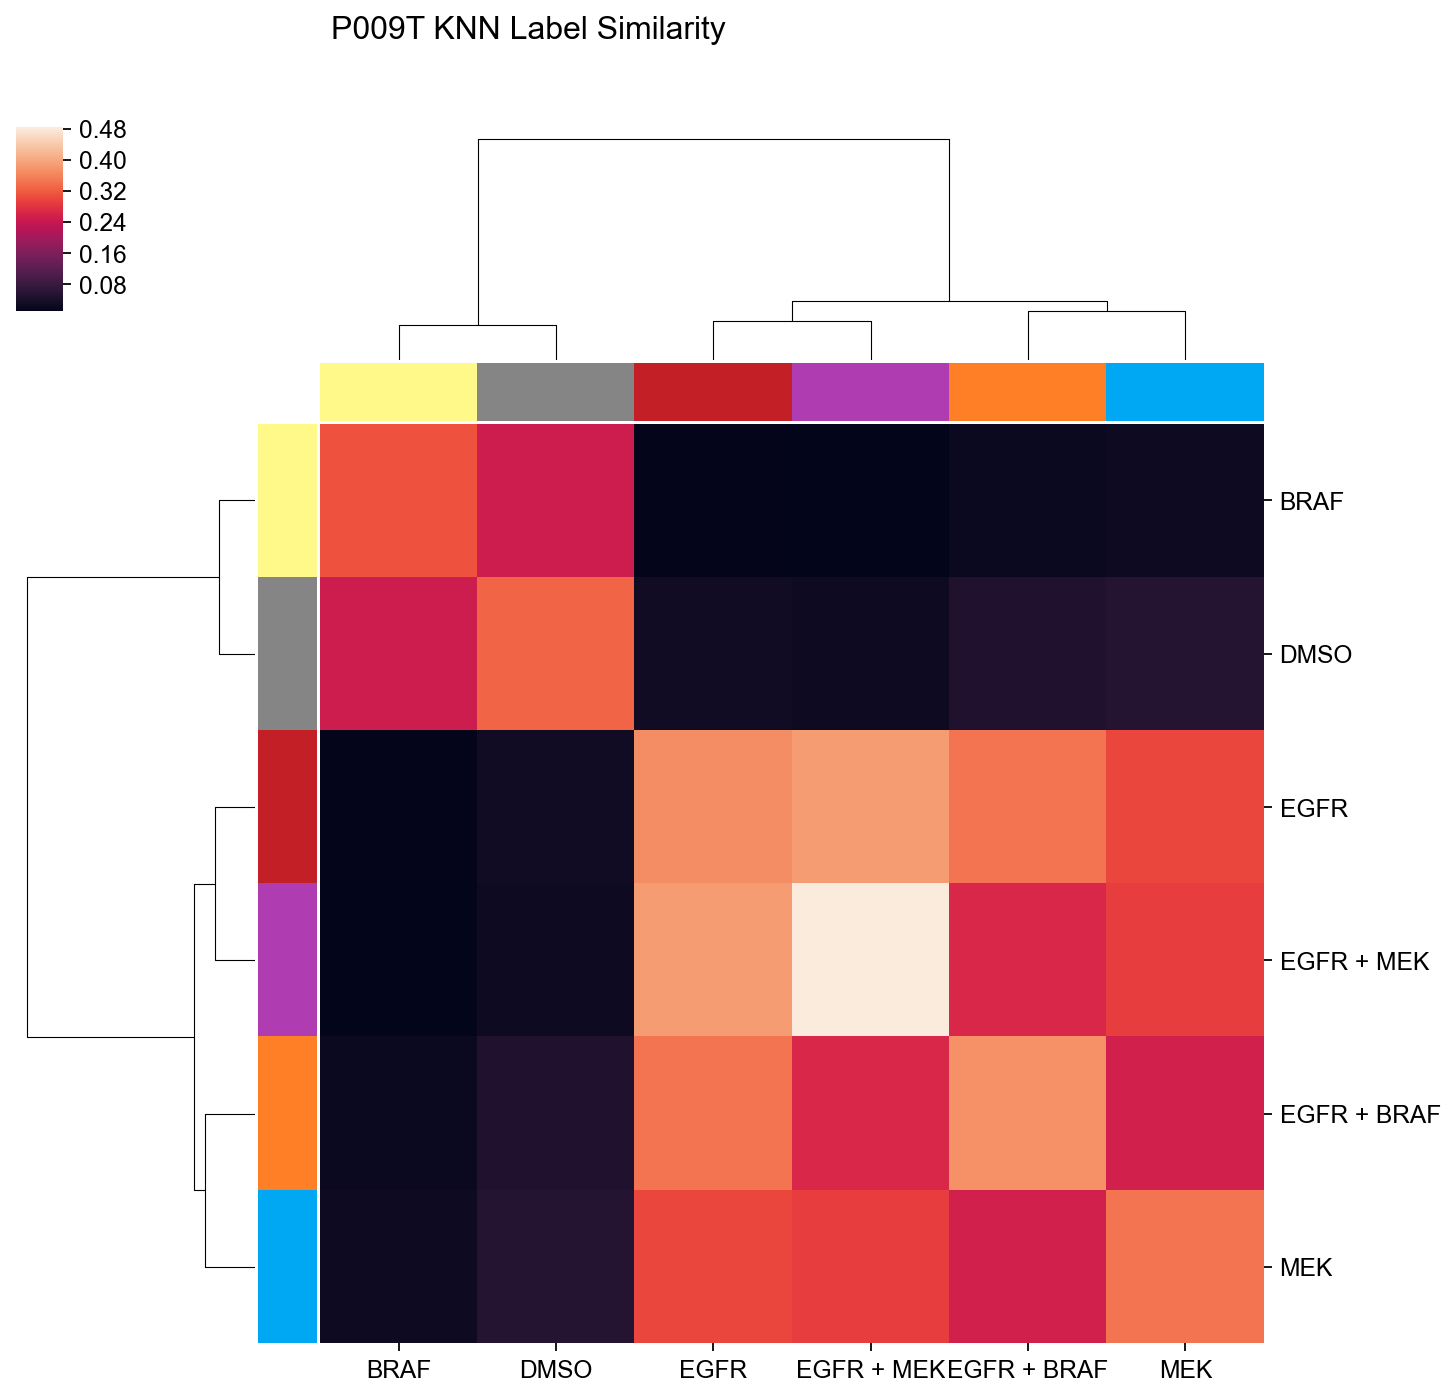

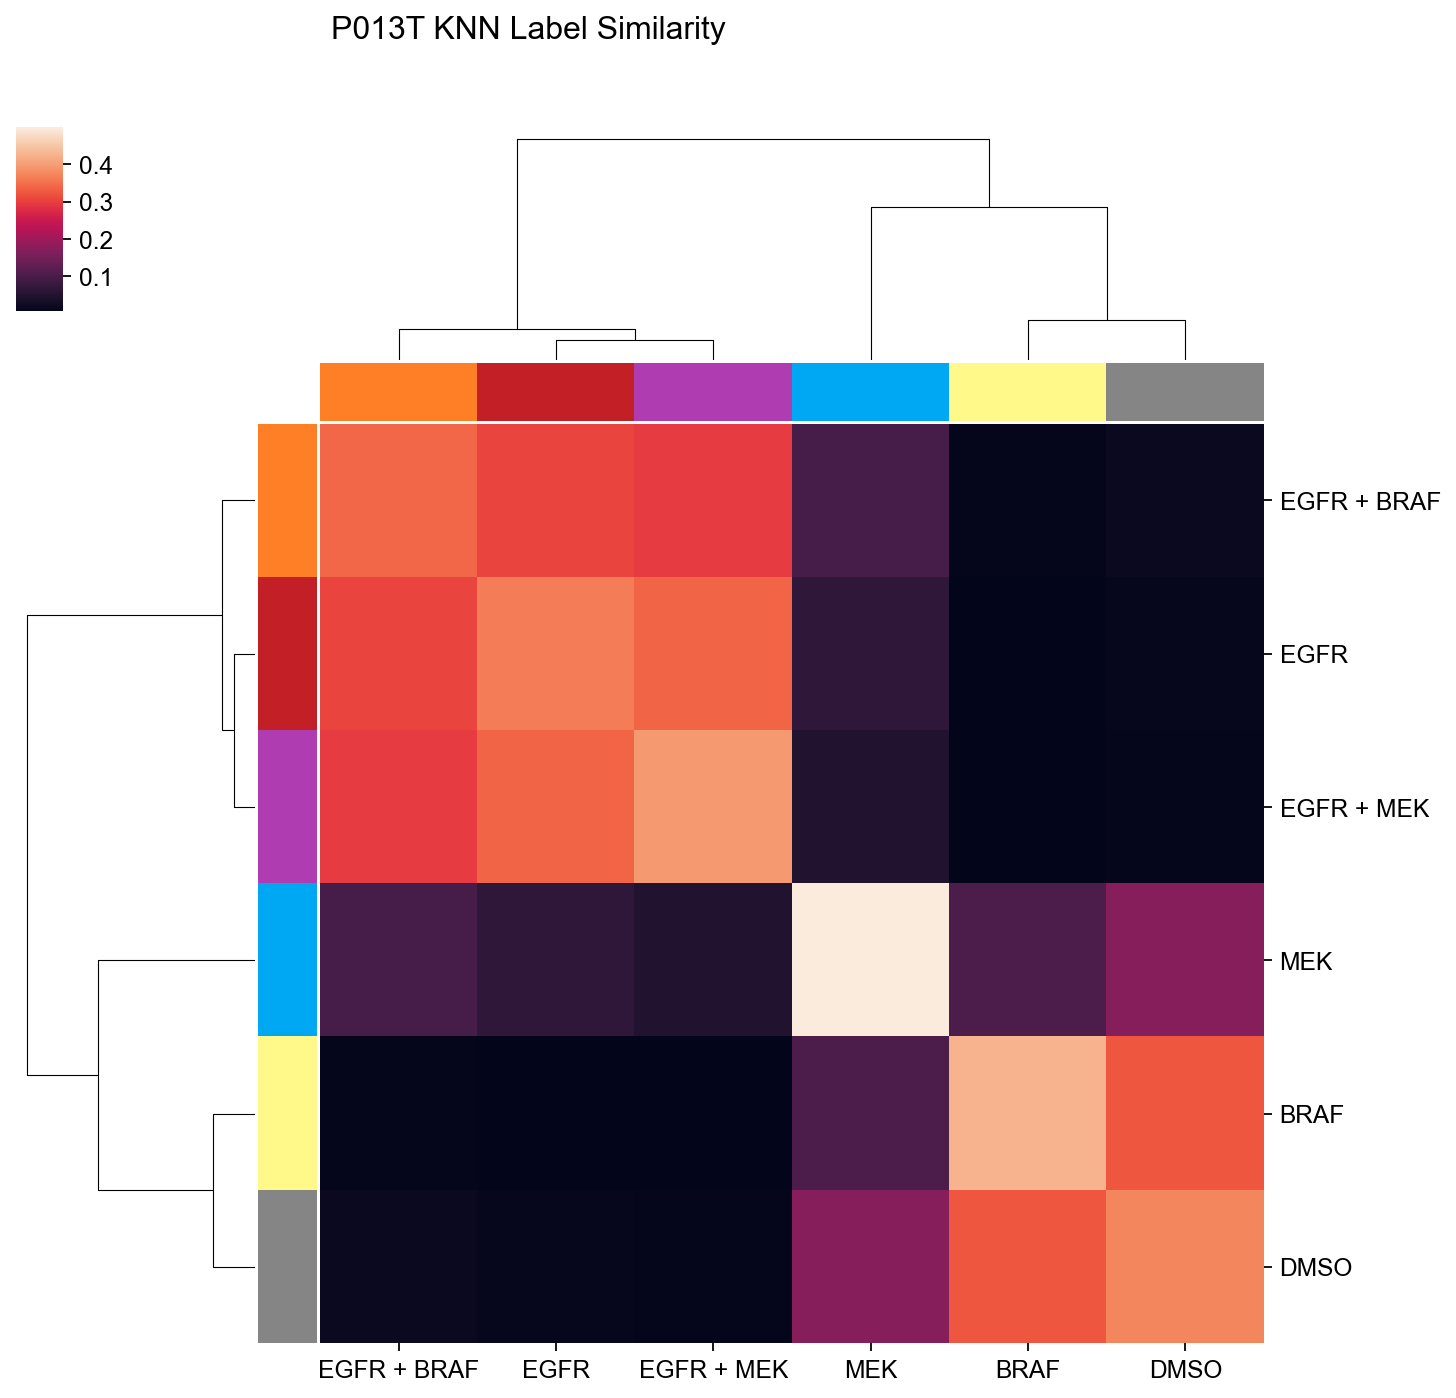

In [35]:
# Plot and save data to excel file
writer = pd.ExcelWriter(figure_path+'perturbation_distance_heatmaps/perturbation_distance_heatmap_values.xlsx', engine='xlsxwriter')
for donor in tqdm_notebook(donors):
    adata=scv.read(data_path+'by_donors/processed/SLAMv2_'+donor+'_processed_ccreg.h5')
    
    # recompute KNN graph
    del adata.obsm['X_diffmap']
    sc.pp.neighbors(adata)

    sim_df = simil(adata)
    
    pl.savefig(figure_path+'perturbation_distance_heatmaps/'+donor+'_perturbation_distance_heatmap.pdf')
    pl.show()
    sim_df.to_excel(writer, sheet_name=donor)
writer.save()